In [1]:
import os
import cv2
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.feature import hog, local_binary_pattern
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Extract ZIP

In [ ]:
zip_path = "/content/archive (1).zip"
extract_dir = "/content/dataset_extracted"

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_dir)

print("ZIP extracted successfully!")
os.listdir(extract_dir)

ZIP extracted successfully!


['Brain_Stroke_CT_Dataset']

# Load Dataset Paths

In [3]:
def load_images_from_folder(base_path):
    images = []
    labels = []

    class_names = sorted(os.listdir(base_path))

    for label_name in class_names:
        class_folder = os.path.join(base_path, label_name)
        if not os.path.isdir(class_folder):
            continue

        for filename in os.listdir(class_folder):
            img_path = os.path.join(class_folder, filename)

            img = cv2.imread(img_path)
            if img is None:
                continue

            images.append(img)
            labels.append(label_name)

    return images, np.array(labels)

images, labels = load_images_from_folder(r"C:\Users\LENOVO\OneDrive\Documents\KULLYEAH\Semester 3\Artificial Intelligence\Project KA\Brain_Stroke_CT_Dataset")

print("Total images:", len(images))
print("Classes:", np.unique(labels))

Total images: 6650
Classes: ['Bleeding' 'Ischemia' 'Normal']


# Preprocessing

In [4]:
def to_gray_128(img_array):
    out = []
    for im in img_array:
        r = cv2.resize(im, (128,128))
        g = cv2.cvtColor(r, cv2.COLOR_BGR2GRAY)
        out.append(g)

    out = np.array(out)
    print("Total grayscale images :", len(out))
    print("Image shape            :", out[0].shape)
    return out

gray_images = to_gray_128(images)

Total grayscale images : 6650
Image shape            : (128, 128)


# Feature Extraction

In [5]:
def get_hog(imgs):
    out = []
    for im in imgs:
        val = hog(im, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
        out.append(val)
    return np.array(out)

def get_lbp(imgs):
    res = []
    for im in imgs:
        rad = 3
        pts = 8 * rad
        lb = local_binary_pattern(im, pts, rad, method="uniform")
        h, _ = np.histogram(lb.ravel(), bins=np.arange(0, pts + 3), range=(0, pts + 2))
        h = h.astype(float)
        h /= (h.sum() + 1e-7)
        res.append(h)
    return np.array(res)

def get_hist(imgs):
    col = []
    for im in imgs:
        temp = []
        for ch in range(3):
            h = cv2.calcHist([im], [ch], None, [32], [0, 256]).flatten()
            temp.extend(h)
        col.append(temp)
    return np.array(col)

def all_features(img_rgb, img_gray):
    print("HOG...")
    hog_f = get_hog(img_gray)
    print("HOG:", hog_f.shape)

    print("LBP...")
    lbp_f = get_lbp(img_gray)
    print("LBP:", lbp_f.shape)

    print("Hist...")
    hist_f = get_hist(img_rgb)
    print("Hist:", hist_f.shape)

    merged = np.hstack([hog_f, lbp_f, hist_f])
    print("Merged:", merged.shape)

    return merged, hog_f, lbp_f, hist_f

X_all, X_hog, X_lbp, X_hist = all_features(images, gray_images)

HOG...
HOG: (6650, 8100)
LBP...
LBP: (6650, 26)
Hist...
Hist: (6650, 96)
Merged: (6650, 8222)


# Normalization

In [6]:
def normalize_features(hog_f, lbp_f, hist_f):
    scaler_std_hog = StandardScaler()
    hog_n = scaler_std_hog.fit_transform(hog_f)

    scaler_std_lbp = StandardScaler()
    lbp_n = scaler_std_lbp.fit_transform(lbp_f)

    scaler_mm = MinMaxScaler()
    hist_n = scaler_mm.fit_transform(hist_f)

    merged = np.hstack([hog_n, lbp_n, hist_n])

    print("HOG normalized      :", hog_n.shape)
    print("LBP normalized      :", lbp_n.shape)
    print("Histogram normalized:", hist_n.shape)
    print("Merged shape        :", merged.shape)

    return merged, scaler_std_hog, scaler_std_lbp, scaler_mm

X_norm, scaler_hog, scaler_lbp, scaler_mm = normalize_features(X_hog, X_lbp, X_hist)

HOG normalized      : (6650, 8100)
LBP normalized      : (6650, 26)
Histogram normalized: (6650, 96)
Merged shape        : (6650, 8222)


# PCA Dimensionality Reduction

In [8]:
def apply_pca(features, n_components=300):
    n_components = min(n_components, features.shape[0], features.shape[1])

    pca = PCA(n_components=n_components)
    reduced = pca.fit_transform(features)

    var = np.sum(pca.explained_variance_ratio_)

    print("Original shape :", features.shape)
    print("PCA shape      :", reduced.shape)
    print(f"Variance kept  : {var:.4f} ({var*100:.2f}%)")

    return reduced, pca

X_pca, pca_model = apply_pca(X_norm, 300)

Original shape : (6650, 8222)
PCA shape      : (6650, 300)
Variance kept  : 0.6496 (64.96%)


# Train/Test Split

In [9]:
def split_data(features, labels, test_size=0.2, seed=42):
    X_tr, X_te, y_tr, y_te = train_test_split(
        features, labels,
        test_size=test_size,
        random_state=seed,
        stratify=labels
    )

    print("Train size :", len(X_tr))
    print("Test size  :", len(X_te))

    return X_tr, X_te, y_tr, y_te

X_train, X_test, y_train, y_test = split_data(X_pca, labels)

Train size : 5320
Test size  : 1330


# Train Decision Tree

In [11]:
from sklearn.model_selection import GridSearchCV

def train_decision_tree_balanced(X_train, y_train):
    param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [8, 10, 12, 15],
        'min_samples_split': [4, 5, 6, 8],
        'min_samples_leaf': [1, 2, 3, 4]
    }

    dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')

    print("Running Grid Search for Decision Tree...")
    grid = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_

    print("\nBest Parameters:")
    for k, v in grid.best_params_.items():
        print(f"  {k}: {v}")
    print(f"Best CV Score: {grid.best_score_:.4f}")

    return best_model, grid.best_params_

model_dt_bal, best_params_bal = train_decision_tree_balanced(X_train, y_train)

Running Grid Search for Decision Tree...
Fitting 5 folds for each of 128 candidates, totalling 640 fits

Best Parameters:
  criterion: gini
  max_depth: 15
  min_samples_leaf: 1
  min_samples_split: 4
Best CV Score: 0.6735


# Evaluation

Accuracy: 0.675187969924812

Classification Report:
               precision    recall  f1-score   support

    Bleeding       0.47      0.48      0.47       219
    Ischemia       0.46      0.53      0.49       226
      Normal       0.80      0.76      0.78       885

    accuracy                           0.68      1330
   macro avg       0.57      0.59      0.58      1330
weighted avg       0.69      0.68      0.68      1330


Confusion Matrix:
 [[105  28  86]
 [ 23 120  83]
 [ 97 115 673]]


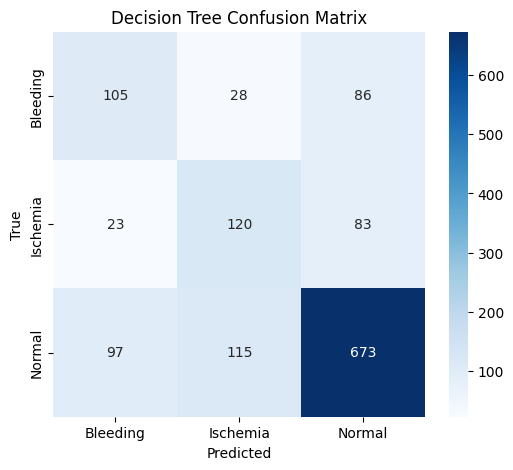

In [12]:
y_pred = model_dt_bal.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(labels),
            yticklabels=np.unique(labels))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Decision Tree Confusion Matrix")
plt.show()

HYPERPARAMETER TUNING DARI TRAINING DECISION TREE

EVALUASI DARI TUNING

# Display Sample Predictions

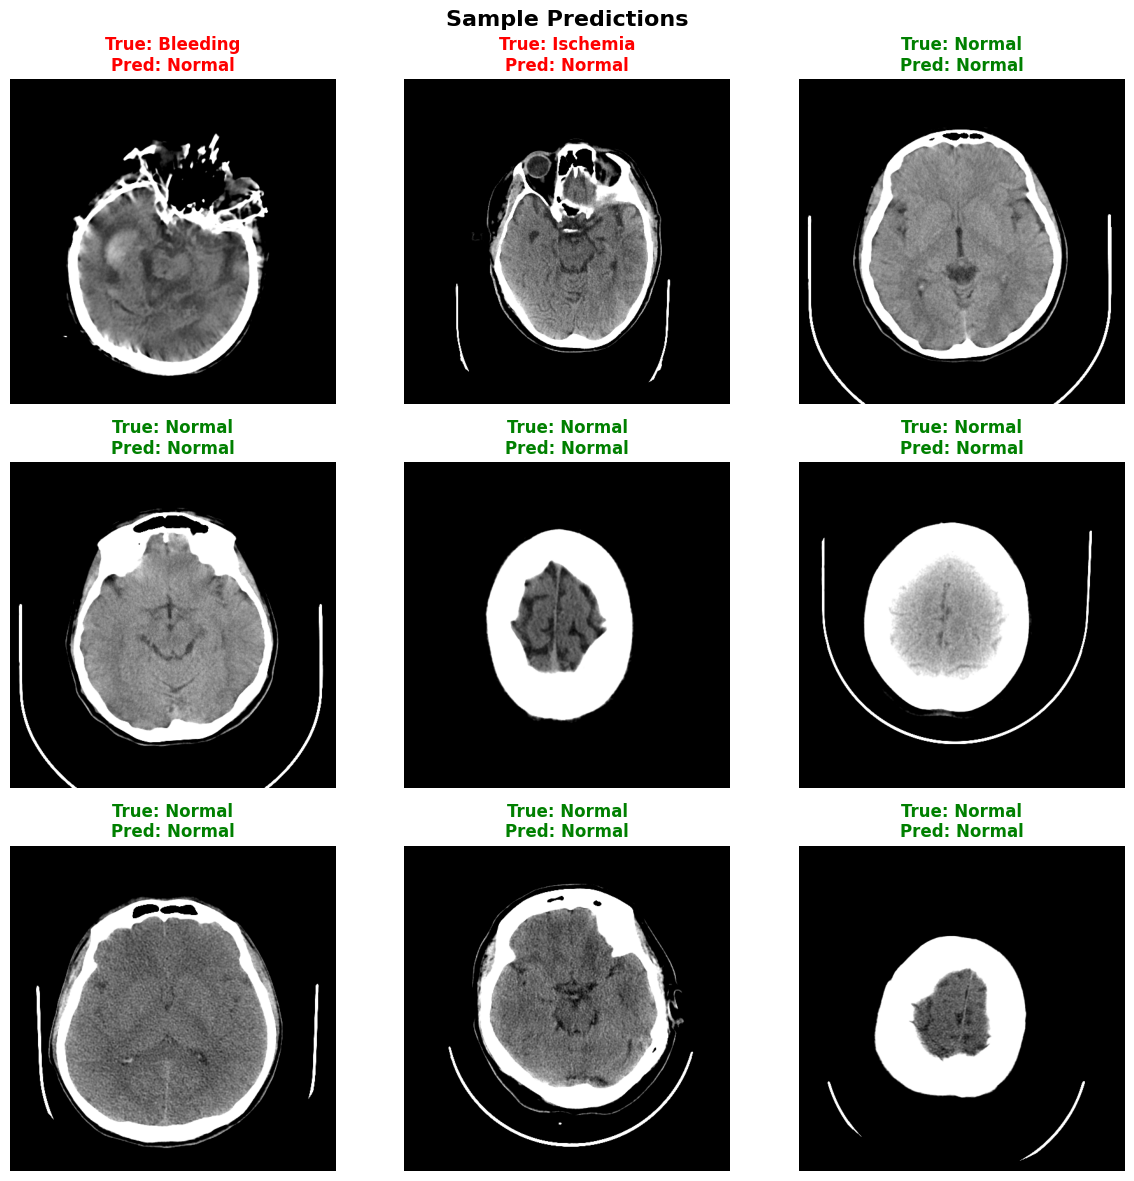

In [13]:
def display_sample_predictions(img_list, y_true, y_pred, class_names, n_samples=9):
    sample_indices = np.random.choice(len(img_list), min(n_samples, len(img_list)), replace=False)

    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < len(sample_indices):
            idx = sample_indices[i]
            img = img_list[idx]
            true_label = y_true[idx]
            pred_label = y_pred[idx]

            if img.ndim == 3:
                ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            else:
                ax.imshow(img, cmap='gray')

            title_color = 'green' if true_label == pred_label else 'red'
            ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=title_color, fontweight='bold')
            ax.axis('off')
        else:
            ax.axis('off')

    plt.suptitle("Sample Predictions", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


_, images_test, _, labels_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

y_pred_test = model_dt_bal.predict(X_test)

class_names = np.unique(labels)

display_sample_predictions(images_test, labels_test, y_pred_test, class_names)

In [14]:
import pickle
with open("decision_tree_model.pkl", "wb") as file:
    pickle.dump(model_dt_bal, file)